In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
import sys
from pathlib import Path
import sys
sys.path.append("../")
from src.model_testing import *
import pickle


In [32]:
#'country' or 'state'
division = 'country'
region = 'United States'
#'ConfirmedCases' or 'ConfirmedDeaths'
prediction = 'ConfirmedCases'

full_df = get_covid_data()
if division == 'country':
    df = full_df[(full_df['Jurisdiction'] == 'NAT_TOTAL') & (full_df['CountryName'] == region)][:-1]
elif division == 'state':
    df = full_df[(full_df['Jurisdiction'] == 'STATE_TOTAL') & (full_df['RegionName'] == region)][:-1]

#remove unneeded columns and set date as index (necessary for SARIMA model)
df = df.iloc[:,5:]
cols = [c for c in df.columns if (c.lower()[-10:] != 'fordisplay') and (c.lower()[-4:] != 'flag')]
df = df[cols]
df = df.set_index('Date', drop=True)

#drop columns with no data and forward-fill missing data after first non nan value
df = df.dropna(how='all', axis=1)
df = df.fillna(method = 'ffill')

#remove days before first infections
df = df[df[prediction] > 0]

#train-test split
train_df = df[df.index < '2020-12-01']
test_df = df[df.index >= '2020-12-01']

additional_regressors = df.drop(columns = [col for col in df.columns if col in ['ConfirmedDeaths','ConfirmedCases']])

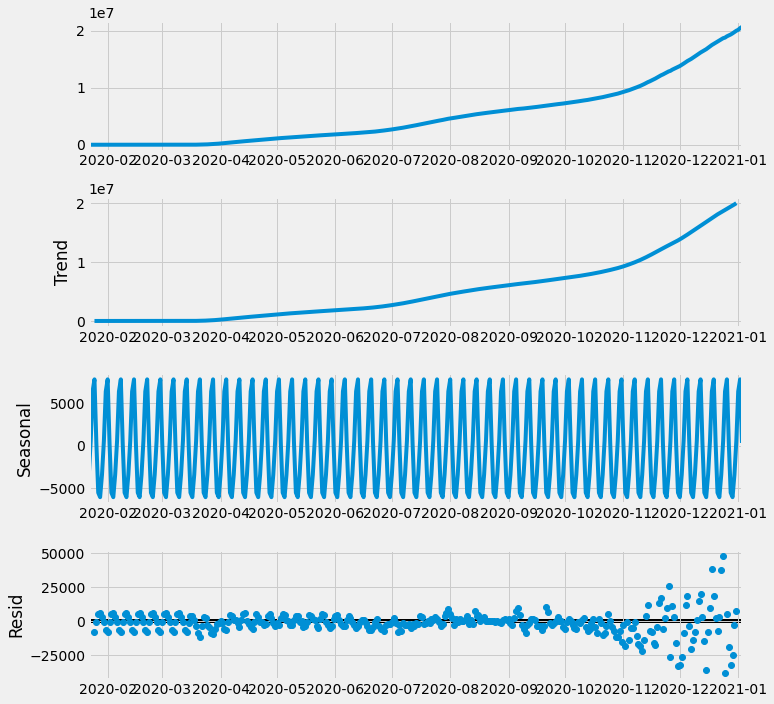

In [40]:
plt.rcParams['figure.figsize'] = [20,10]
results = seasonal_decompose(df[['ConfirmedCases']])
results.plot().set_size_inches(10,10)


Above, we see a weekly seasonality in the decomposition.  We also see exploding variance in the residuals after October.  We also see that the decomposition failed to revmove the seasonality in the residuals for the first half of the year.

Lets see if we can get a better decomposition

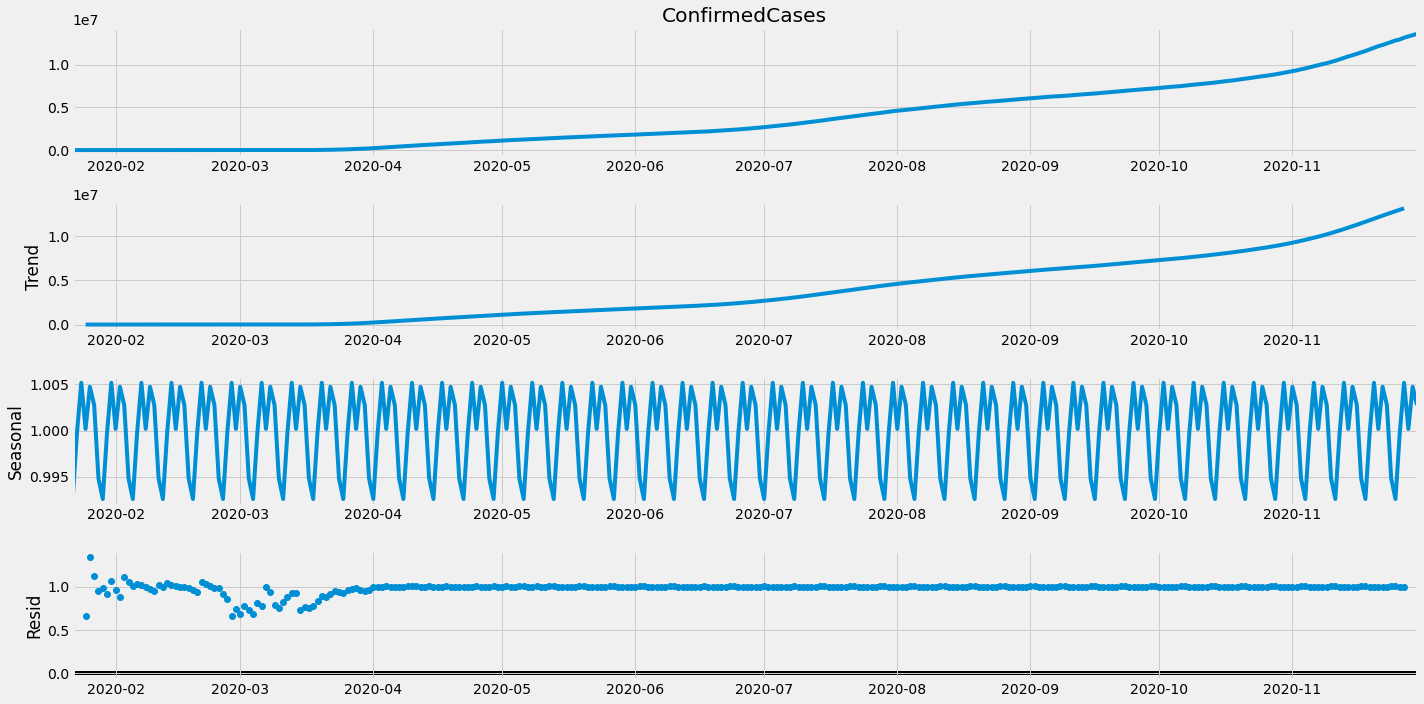

In [41]:
results = seasonal_decompose(train_df['ConfirmedCases'],two_sided = True, model='multiplicative')
results.plot()
plt.show()

Let's take a look at this seasonality.  Where is it coming from?  


The below bar plot of average infections per day of the week suggests that test results are most often reported on Mondays and least often reported on Wednesdays.  The number of reports seems to escalate steadily from Wednesday to Monday. It seems unlikely that these numbers represent the days people are actually infected on.  I imagine the data is entered sometime after tests come back, which is between 2 and 5 days after testing.  PCR tests are most accurate 5+ days after exposure, so we can assume reported cases lag by 7-10 days.  I would guess that the greater number of reports on Mondays has to do with either the workflow patterns in laboratories, or the patterns of when people tend to go in for tests. 

NOTE: y-axis begins at 3.6m.

Text(0.5, 0, 'Day of the Week')

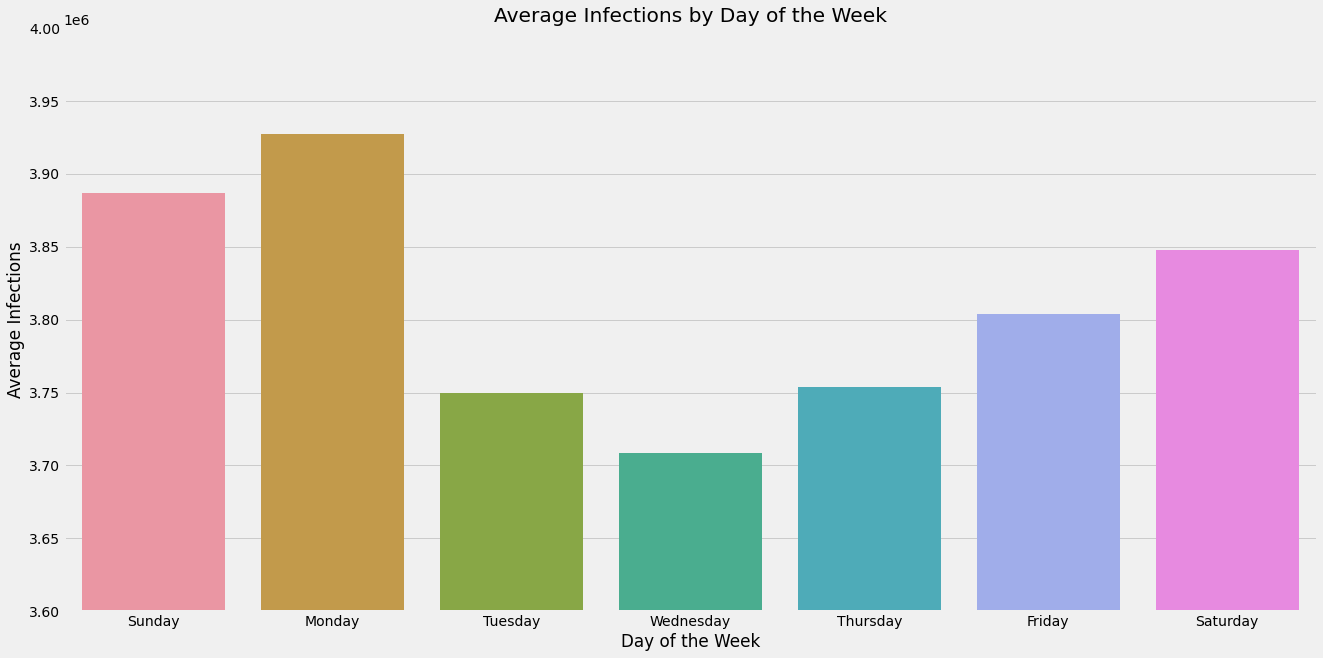

In [59]:
import seaborn as sns
ax = plt.subplot()
sns.barplot(x=train_df.index.day_name(), y=train_df[prediction].values, ax=ax, ci=False,
           order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
ax.set_ylim([3600000,4000000])
ax.set_title('Average Infections by Day of the Week')
ax.set_ylabel('Average Infections')
ax.set_xlabel('Day of the Week')

# SARIMA

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In our ACF plot we see the effects of our weekly seasonality at 7, 14, and 21 days.  We also see jumps in autocorrelation in the days before and after those.  My guess is that testing is most often done on weekends.  Let's do a visual inspection to see if that is true.

In [68]:
train = train_df[prediction]
test = test_df[prediction]
true = df[prediction]
train.index.freq = 'D'
test.index.freq = 'D'
true.index.freq = 'D'

# Testing for Stationarity

In [89]:
from statsmodels.tsa.stattools import adfuller


First, let's see if we can remove the seasonality with some log scaling, since the scale of cases keeps rising.

(-1.0312363141145753,
 0.9397611516713353,
 4,
 343,
 {'1%': -3.9854088360500213,
  '5%': -3.4233679291427404,
  '10%': -3.134622108966616},
 -1113.1879833744804)

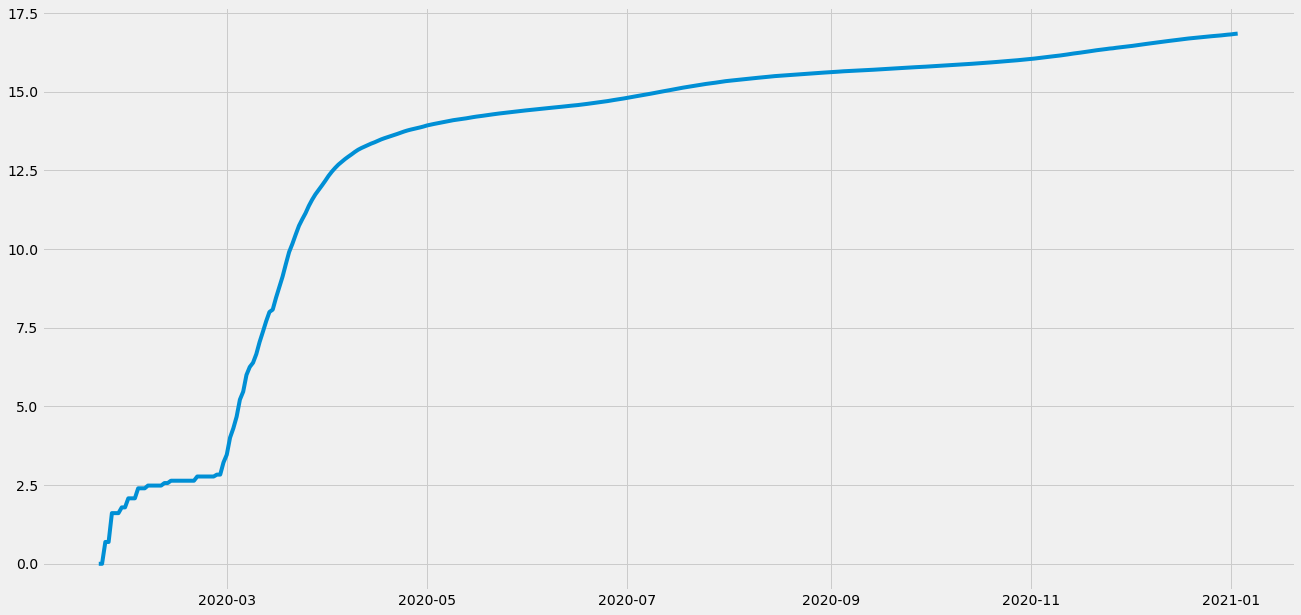

In [137]:
log_true = np.log(true).dropna()
plt.plot(log_true)
adresults = adfuller(log_true, maxlag = 10, autolag = 'BIC', regression = 'ct')
adresults

Now let's see if we can isolate the trend by subtracting the rolling mean.

(-2.8597343746428727,
 0.17587006914580183,
 9,
 332,
 {'1%': -3.986299950657981,
  '5%': -3.4237973148195917,
  '10%': -3.1348741726814358},
 -1226.3200581019298)

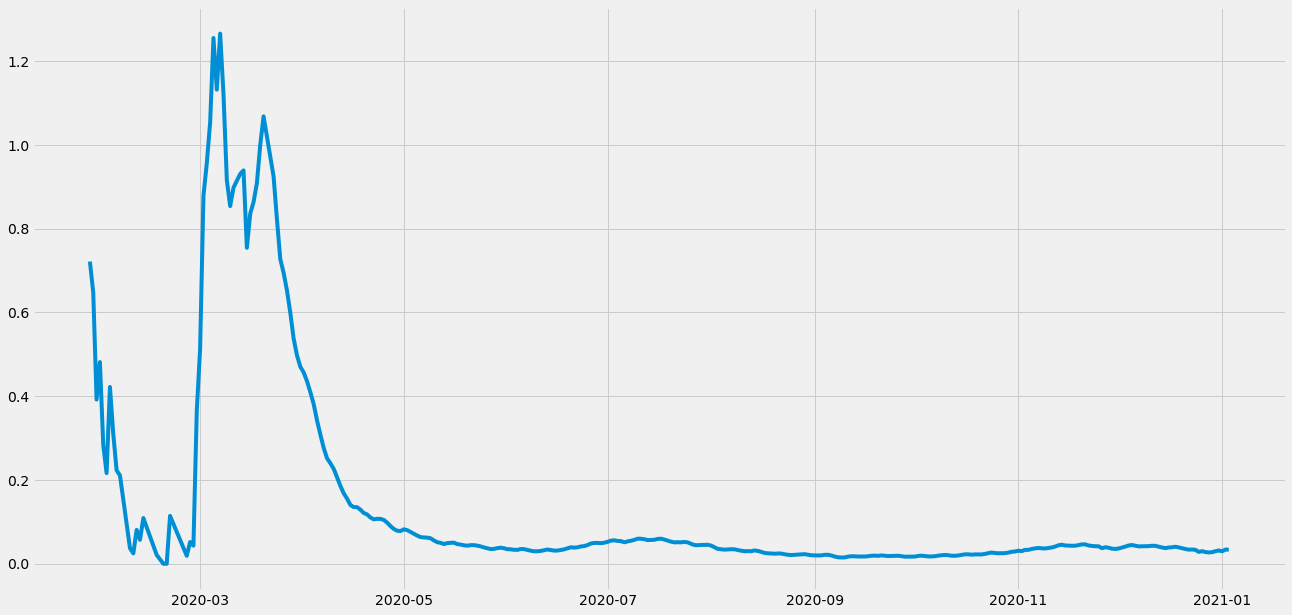

In [142]:
log_rolling = (log_true - log_true.rolling(window=7).mean()).dropna()
plt.plot(log_rolling)
adresults = adfuller(log_rolling, autolag = 'BIC', regression = 'ct')
adresults

That removed the jump at the end, but I can still seem some evenly spaced bumps.  I believe the weekly seasonality is still there.  Let's see if that can remove the seasonality.

(-8.638498852672228,
 2.4137050820931026e-12,
 3,
 337,
 {'1%': -3.9858876182413634,
  '5%': -3.423598642683739,
  '10%': -3.134757548798489},
 -1244.5769432720592)

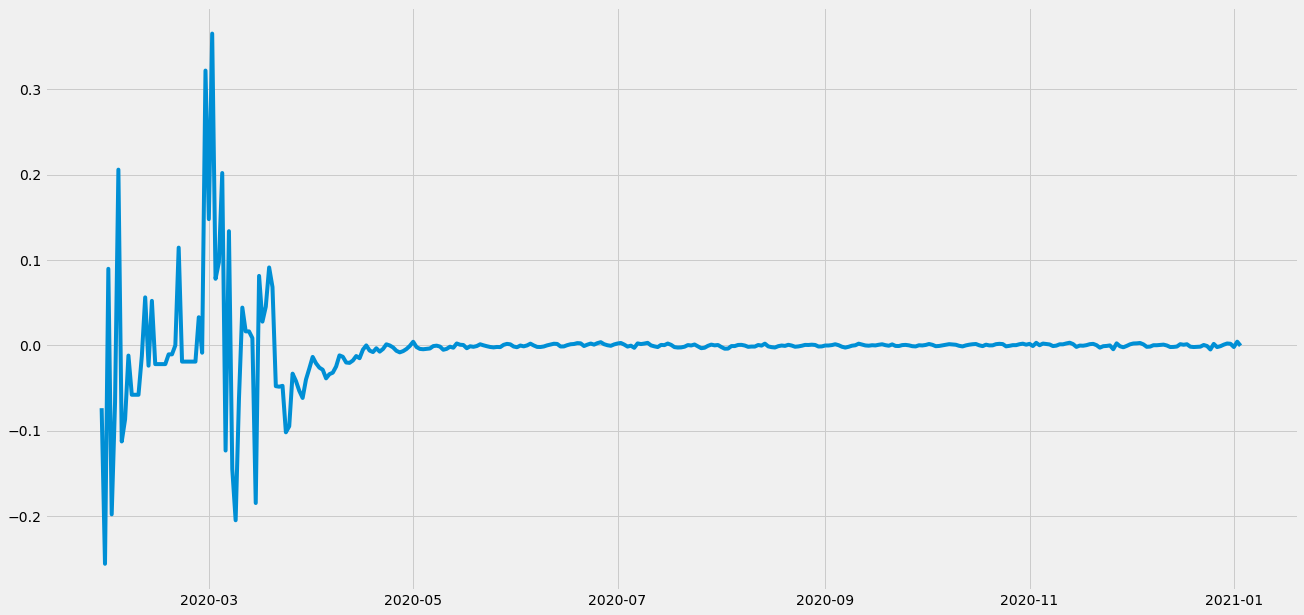

In [143]:
rolling_diff = log_rolling.diff(1).dropna()
plt.plot(rolling_diff)
adresults = adfuller(rolling_diff, maxlag = 10, autolag = 'BIC', regression = 'ct')
adresults

Difference order = 2

(-10.312601320751885,
 5.127823456501619e-16,
 8,
 331,
 {'1%': -3.9863839265077425,
  '5%': -3.423837774131041,
  '10%': -3.1348979222834137},
 -1191.7139797750729)

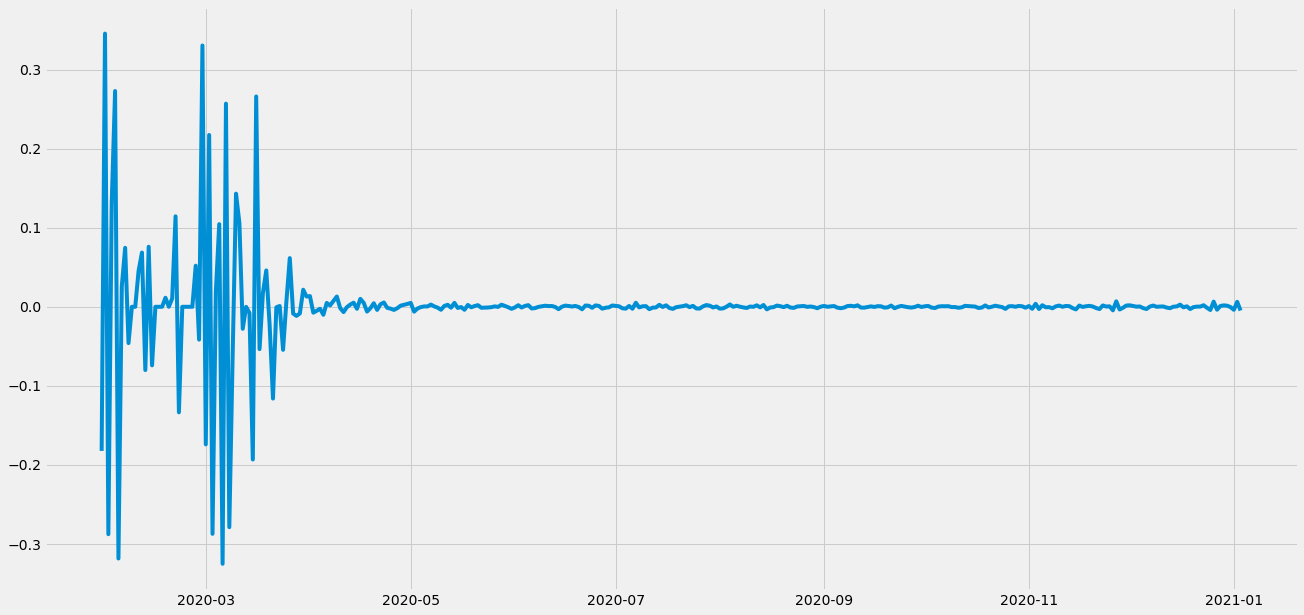

In [144]:
rolling_diff2 = log_rolling.diff(1).diff(1).dropna()
plt.plot(rolling_diff2)
adresults = adfuller(rolling_diff2, maxlag = 10, autolag = 'BIC', regression = 'ct')
adresults

(-3.5606769108643066,
 0.03333287985733858,
 7,
 239,
 {'1%': -3.99715658668426,
  '5%': -3.4290213886201637,
  '10%': -3.137938763154836},
 -2400.054829287735)

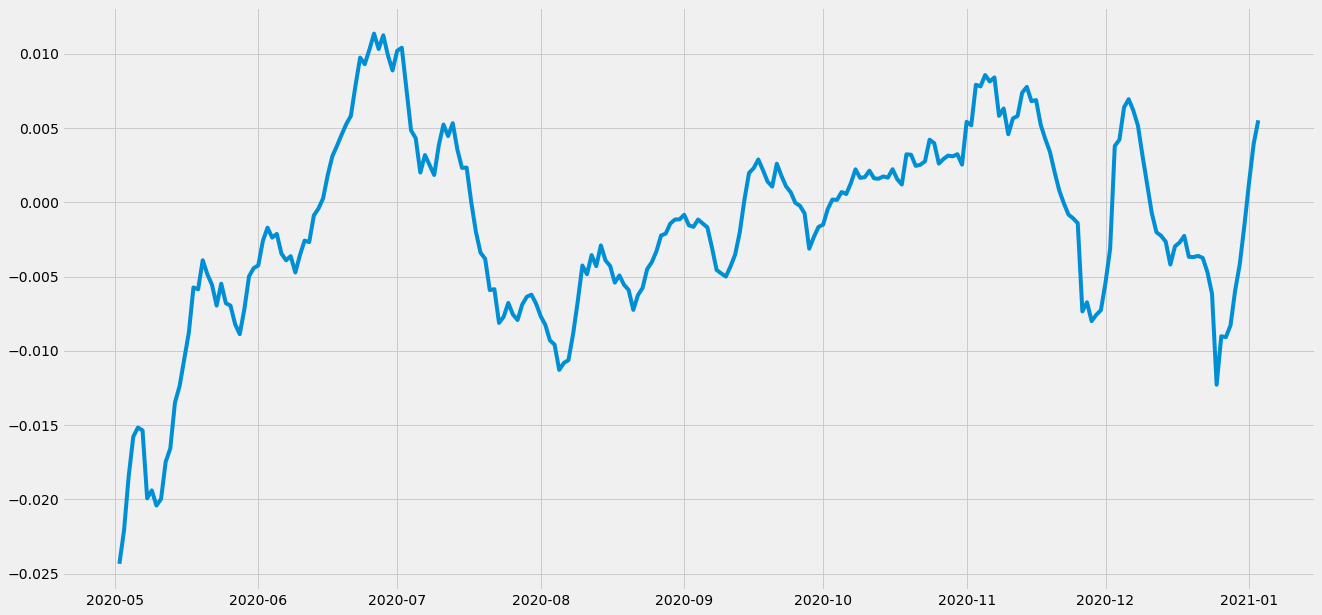

In [166]:
rolling_diff_week = log_rolling.diff(7).dropna()
plt.plot(rolling_diff_week[rolling_diff_week.index > '2020-05-01'])
adresults = adfuller(rolling_diff_week[rolling_diff_week.index > '2020-05-01'], autolag = 'BIC', regression = 'ct')
adresults

We pass the Dicky-Fuller test now, but the standard deviations are off as the year progresses.  Let's try some scaling.

We may want to try both 1st and 2nd order differencing for our model selection, as 1 order has a lower BIC, but 2 orders has a better pvalue and test-statistic

But, what about the AR and MA values?

In [147]:
sarimamodel = SARIMAX(train, order = (1,1,1), seasonal_order = (1,1,0,7))
fit_model = sarimamodel.fit()

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [ ]:
def eval_model(fit_model, test, yhat, metric = 'RMSE'):
    unlogyhat = np.exp(yhat)
    unlogtest = np.exp(test)
    if (unlogyhat.isna().sum() == 0) & (np.isinf(unlogyhat).sum() == 0):
        if (unlogtest.isna().sum() == 0) & (np.isinf(unlogtest).sum() == 0):
            if metric == 'RMSE':
                return np.sqrt(mean_squared_error(unlogtest,unlogyhat))
            elif metric == 'MSE':
                return mean_squared_error(unlogtest, unlogyhat)
            elif metric == 'MAE':
                return (unlogtest - unlogyhat).abs().sum() / len(unlogtest)
            elif 
        else:
            print('test set contains nans or infs')
            return np.nan
    else: 
        print('prediction contains nans or infs')
        return np.nan
                    


In [204]:
test_results = pd.DataFrame(columns = ['RMSE'])
for p in range(0,4):
    for d in range(1,3):
        for q in range(0,4):
            for P in range(0,4):
                for D in range(1,3):
                    for Q in range(0,4):
                        model = SARIMAX(train, order =(p,d,q), seasonal_order = (P,D,Q,7),
                                       freq = 'D')
                        fit_model = model.fit(maxiter = 200, disp = False)
                        yhat = fit_model.forecast(len(test))
                        ind = f'order = ({p},{d},{q}), seasonal_order = ({P},{D},{Q},7)'
                        test_results.loc[ind,'RMSE'] = eval_model(fit_model,test,yhat)

test_results.min()

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\caell\new_A

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-pac

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\caell\new_A

LinAlgError: LU decomposition error.

In [208]:
test_results.min()

RMSE    29086.209962
dtype: float64

In [218]:
test_results.sort_values(by = 'RMSE').head(10)

,RMSE
"order = (0,1,0), seasonal_order = (3,1,0,7)",29086.2
"order = (0,1,1), seasonal_order = (3,1,0,7)",29234.6
"order = (1,1,1), seasonal_order = (3,1,0,7)",29240.9
"order = (0,1,2), seasonal_order = (3,1,0,7)",29242.6
"order = (0,1,3), seasonal_order = (3,1,0,7)",29290.4
"order = (1,1,0), seasonal_order = (3,1,0,7)",29318.8
"order = (0,2,2), seasonal_order = (2,1,2,7)",29881.2
"order = (0,1,3), seasonal_order = (0,1,0,7)",30100.2
"order = (0,1,2), seasonal_order = (0,1,0,7)",30348.2
"order = (1,1,1), seasonal_order = (0,1,0,7)",30367.6


In [224]:
test_results2 = pd.DataFrame(columns = ['RMSE'])
for p in range(0,2):
    for d in range(1,4):
        for q in range(0,5):
            for P in [0,2,3,4]:
                for D in range(0,2):
                    for Q in [2,0,3]:
                        ind = f'order = ({p},{d},{q}), seasonal_order = ({P},{D},{Q},7)'
                        model = SARIMAX(train, order =(p,d,q), seasonal_order = (P,D,Q,7),
                                       freq = 'D')
                        try:
                            fit_model = model.fit(maxiter = 200, disp = False)
                            yhat = fit_model.forecast(len(test))
                            RMSE = eval_model(fit_model,test,yhat)
                            print(f'trying {ind}, RMSE = {RMSE}')
                            test_results.loc[ind,'RMSE'] = RMSE
                        except:
                            print('LinAlgError: LU decomposition error')
                            print(f'{ind} not built')


test_results.dropna()[test_results['RMSE'] == test_results['RMSE'].min()]

trying order = (0,1,0), seasonal_order = (0,0,2,7), RMSE = 94090.95141844693
trying order = (0,1,0), seasonal_order = (0,0,0,7), RMSE = 101595.51818608938
trying order = (0,1,0), seasonal_order = (0,0,3,7), RMSE = 88633.34923056443
trying order = (0,1,0), seasonal_order = (0,1,2,7), RMSE = 83395.65408988667
trying order = (0,1,0), seasonal_order = (0,1,0,7), RMSE = 69414.42165781718
trying order = (0,1,0), seasonal_order = (0,1,3,7), RMSE = 83410.7433244378
trying order = (0,1,0), seasonal_order = (2,0,2,7), RMSE = 85547.2470305114
trying order = (0,1,0), seasonal_order = (2,0,0,7), RMSE = 69736.01498221209
trying order = (0,1,0), seasonal_order = (2,0,3,7), RMSE = 84976.43178461997
trying order = (0,1,0), seasonal_order = (2,1,2,7), RMSE = 84122.26794862408
trying order = (0,1,0), seasonal_order = (2,1,0,7), RMSE = 40416.396415503776
trying order = (0,1,0), seasonal_order = (2,1,3,7), RMSE = 87815.76938870178
trying order = (0,1,0), seasonal_order = (3,0,2,7), RMSE = 84959.05333534385

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,1,2), seasonal_order = (3,0,3,7), RMSE = 85279.06018863979
trying order = (0,1,2), seasonal_order = (3,1,2,7), RMSE = 83776.65490836024
trying order = (0,1,2), seasonal_order = (3,1,0,7), RMSE = 29242.559803346077
trying order = (0,1,2), seasonal_order = (3,1,3,7), RMSE = 84691.87303422065
trying order = (0,1,2), seasonal_order = (4,0,2,7), RMSE = 84406.71710917032
trying order = (0,1,2), seasonal_order = (4,0,0,7), RMSE = 43970.935130117185
trying order = (0,1,2), seasonal_order = (4,0,3,7), RMSE = 88345.59589277767
trying order = (0,1,2), seasonal_order = (4,1,2,7), RMSE = 78918.74791089905
trying order = (0,1,2), seasonal_order = (4,1,0,7), RMSE = 30276.21431425822
trying order = (0,1,2), seasonal_order = (4,1,3,7), RMSE = 78918.59131240367
trying order = (0,1,3), seasonal_order = (0,0,2,7), RMSE = 99414.75897059285
trying order = (0,1,3), seasonal_order = (0,0,0,7), RMSE = 105638.4450829001
trying order = (0,1,3), seasonal_order = (0,0,3,7), RMSE = 93987.144040959

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,1,3), seasonal_order = (0,1,2,7), RMSE = 85073.47645883162
trying order = (0,1,3), seasonal_order = (0,1,0,7), RMSE = 30100.158583153523
trying order = (0,1,3), seasonal_order = (0,1,3,7), RMSE = 83879.17483222006
trying order = (0,1,3), seasonal_order = (2,0,2,7), RMSE = 86818.64347252465
trying order = (0,1,3), seasonal_order = (2,0,0,7), RMSE = 66730.24485211803
trying order = (0,1,3), seasonal_order = (2,0,3,7), RMSE = 85472.38439446528
trying order = (0,1,3), seasonal_order = (2,1,2,7), RMSE = 83959.04547237937
trying order = (0,1,3), seasonal_order = (2,1,0,7), RMSE = 35017.34818922932
trying order = (0,1,3), seasonal_order = (2,1,3,7), RMSE = 84530.66122793604
trying order = (0,1,3), seasonal_order = (3,0,2,7), RMSE = 84849.68900619565
trying order = (0,1,3), seasonal_order = (3,0,0,7), RMSE = 51437.311339058506


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,1,3), seasonal_order = (3,0,3,7), RMSE = 84955.4018908736
trying order = (0,1,3), seasonal_order = (3,1,2,7), RMSE = 83476.62522385358
trying order = (0,1,3), seasonal_order = (3,1,0,7), RMSE = 29290.444137261202
trying order = (0,1,3), seasonal_order = (3,1,3,7), RMSE = 84223.10378005254
trying order = (0,1,3), seasonal_order = (4,0,2,7), RMSE = 84278.78317572083
trying order = (0,1,3), seasonal_order = (4,0,0,7), RMSE = 43546.57239198902


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,1,3), seasonal_order = (4,0,3,7), RMSE = 88233.47682170966
trying order = (0,1,3), seasonal_order = (4,1,2,7), RMSE = 78615.52687242138
trying order = (0,1,3), seasonal_order = (4,1,0,7), RMSE = 30152.344862217968
trying order = (0,1,3), seasonal_order = (4,1,3,7), RMSE = 78454.02628053728
trying order = (0,1,4), seasonal_order = (0,0,2,7), RMSE = 99865.94468667131
trying order = (0,1,4), seasonal_order = (0,0,0,7), RMSE = 105697.92950452864
trying order = (0,1,4), seasonal_order = (0,0,3,7), RMSE = 94569.98071322762
trying order = (0,1,4), seasonal_order = (0,1,2,7), RMSE = 85144.57688360782
trying order = (0,1,4), seasonal_order = (0,1,0,7), RMSE = 30263.96384934791
trying order = (0,1,4), seasonal_order = (0,1,3,7), RMSE = 83983.42210121006
trying order = (0,1,4), seasonal_order = (2,0,2,7), RMSE = 87039.24828291404
trying order = (0,1,4), seasonal_order = (2,0,0,7), RMSE = 67661.416891971
trying order = (0,1,4), seasonal_order = (2,0,3,7), RMSE = 85711.45282390108

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,1,4), seasonal_order = (3,0,3,7), RMSE = 85548.45368233
trying order = (0,1,4), seasonal_order = (3,1,2,7), RMSE = 83554.64501853513
trying order = (0,1,4), seasonal_order = (3,1,0,7), RMSE = 29111.10180268517
trying order = (0,1,4), seasonal_order = (3,1,3,7), RMSE = 84661.86698901562
trying order = (0,1,4), seasonal_order = (4,0,2,7), RMSE = 84469.4864996222
trying order = (0,1,4), seasonal_order = (4,0,0,7), RMSE = 44938.025710196496
trying order = (0,1,4), seasonal_order = (4,0,3,7), RMSE = 88617.21164503224
trying order = (0,1,4), seasonal_order = (4,1,2,7), RMSE = 78843.32679485454
trying order = (0,1,4), seasonal_order = (4,1,0,7), RMSE = 30306.860389361496


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,1,4), seasonal_order = (4,1,3,7), RMSE = 78759.74720266543
trying order = (0,2,0), seasonal_order = (0,0,2,7), RMSE = 63270505.604604945


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,2,0), seasonal_order = (0,0,0,7), RMSE = 26877830.82456709
trying order = (0,2,0), seasonal_order = (0,0,3,7), RMSE = 21123791.42811823
trying order = (0,2,0), seasonal_order = (0,1,2,7), RMSE = 58736.324063911045
trying order = (0,2,0), seasonal_order = (0,1,0,7), RMSE = 1.2069087940092208e+26
trying order = (0,2,0), seasonal_order = (0,1,3,7), RMSE = 63952.48501500289
trying order = (0,2,0), seasonal_order = (2,0,2,7), RMSE = 103734.4158725444
trying order = (0,2,0), seasonal_order = (2,0,0,7), RMSE = 22656294.142801236
trying order = (0,2,0), seasonal_order = (2,0,3,7), RMSE = 108948.56605836419
trying order = (0,2,0), seasonal_order = (2,1,2,7), RMSE = 122817.21857982533
trying order = (0,2,0), seasonal_order = (2,1,0,7), RMSE = 1083736.9269919125
trying order = (0,2,0), seasonal_order = (2,1,3,7), RMSE = 63594.68716254818
trying order = (0,2,0), seasonal_order = (3,0,2,7), RMSE = 109107.02384111314
trying order = (0,2,0), seasonal_order = (3,0,0,7), RMSE = 594744

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (0,1,2,7), RMSE = 61937.386230254735


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (0,1,0,7), RMSE = 69648.44313764398


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (0,1,3,7), RMSE = 63186.1182187685


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,2,1), seasonal_order = (2,0,2,7), RMSE = 77694.70961145104
trying order = (0,2,1), seasonal_order = (2,0,0,7), RMSE = 51033.4783904993
trying order = (0,2,1), seasonal_order = (2,0,3,7), RMSE = 80003.18695908764


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (2,1,2,7), RMSE = 65531.46055123099


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (2,1,0,7), RMSE = 58910.68735891426


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (2,1,3,7), RMSE = 66187.53552272092
trying order = (0,2,1), seasonal_order = (3,0,2,7), RMSE = 77717.07573940691
trying order = (0,2,1), seasonal_order = (3,0,0,7), RMSE = 37788.537874084555
trying order = (0,2,1), seasonal_order = (3,0,3,7), RMSE = 84212.45126525148


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (3,1,2,7), RMSE = 66574.29101648237


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (3,1,0,7), RMSE = 39861.56089450908


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (3,1,3,7), RMSE = 66260.69085651051
trying order = (0,2,1), seasonal_order = (4,0,2,7), RMSE = 81316.94242764269
trying order = (0,2,1), seasonal_order = (4,0,0,7), RMSE = 36601.76431975076
trying order = (0,2,1), seasonal_order = (4,0,3,7), RMSE = 87108.85508193559


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (4,1,2,7), RMSE = 61997.84828854748


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (4,1,0,7), RMSE = 35078.81944852132


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,1), seasonal_order = (4,1,3,7), RMSE = 61566.93334364476


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,2), seasonal_order = (0,0,2,7), RMSE = 86859.19981315406


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,2), seasonal_order = (0,0,0,7), RMSE = 88465.33757536122


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,2), seasonal_order = (0,0,3,7), RMSE = 81121.82985034908
trying order = (0,2,2), seasonal_order = (0,1,2,7), RMSE = 37626.77320610374
trying order = (0,2,2), seasonal_order = (0,1,0,7), RMSE = 34366.629997528085
trying order = (0,2,2), seasonal_order = (0,1,3,7), RMSE = 38138.208131548585


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LinAlgError: LU decomposition error
order = (0,2,2), seasonal_order = (2,0,2,7) not built
trying order = (0,2,2), seasonal_order = (2,0,2,7), RMSE = 38138.208131548585


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,2), seasonal_order = (2,0,0,7), RMSE = 47053.84421388549


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,2), seasonal_order = (2,0,3,7), RMSE = 70180.51517633046
trying order = (0,2,2), seasonal_order = (2,1,2,7), RMSE = 29881.159983797268
trying order = (0,2,2), seasonal_order = (2,1,0,7), RMSE = 161766.36168577577
trying order = (0,2,2), seasonal_order = (2,1,3,7), RMSE = 45032.16824623785


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,2), seasonal_order = (3,0,2,7), RMSE = 75324.29981516761
trying order = (0,2,2), seasonal_order = (3,0,0,7), RMSE = 35353.597810715844


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,2), seasonal_order = (3,0,3,7), RMSE = 42242.065776042546
trying order = (0,2,2), seasonal_order = (3,1,2,7), RMSE = 36621.9835077028
trying order = (0,2,2), seasonal_order = (3,1,0,7), RMSE = 353439.51048527856
trying order = (0,2,2), seasonal_order = (3,1,3,7), RMSE = 46577.28778471213


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,2), seasonal_order = (4,0,2,7), RMSE = 75439.47874421936
trying order = (0,2,2), seasonal_order = (4,0,0,7), RMSE = 177996.22935601327


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,2,2), seasonal_order = (4,0,3,7), RMSE = 43963.401507780305
trying order = (0,2,2), seasonal_order = (4,1,2,7), RMSE = 46768.6765467724
trying order = (0,2,2), seasonal_order = (4,1,0,7), RMSE = 261325.49290305335
trying order = (0,2,2), seasonal_order = (4,1,3,7), RMSE = 53962.7093557687


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,3), seasonal_order = (0,0,2,7), RMSE = 31766.85210797201
trying order = (0,2,3), seasonal_order = (0,0,0,7), RMSE = 35930.468215418114


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,3), seasonal_order = (0,0,3,7), RMSE = 31255.18957306408
trying order = (0,2,3), seasonal_order = (0,1,2,7), RMSE = 47147.00115694388
trying order = (0,2,3), seasonal_order = (0,1,0,7), RMSE = 32845.15754524955
trying order = (0,2,3), seasonal_order = (0,1,3,7), RMSE = 47709.12961588527


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,3), seasonal_order = (2,0,2,7), RMSE = 48543.998600093895


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,3), seasonal_order = (2,0,0,7), RMSE = 50867.478045276024


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,3), seasonal_order = (2,0,3,7), RMSE = 71050.8182193981
trying order = (0,2,3), seasonal_order = (2,1,2,7), RMSE = 48195.26856454269
trying order = (0,2,3), seasonal_order = (2,1,0,7), RMSE = 353762.5179698019
trying order = (0,2,3), seasonal_order = (2,1,3,7), RMSE = 49065.0434725113


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,3), seasonal_order = (3,0,2,7), RMSE = 66212.61752340928


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,3), seasonal_order = (3,0,0,7), RMSE = 129039.1436982032


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,3), seasonal_order = (3,0,3,7), RMSE = 49907.234365467935
trying order = (0,2,3), seasonal_order = (3,1,2,7), RMSE = 46868.65587244961
trying order = (0,2,3), seasonal_order = (3,1,0,7), RMSE = 381296.9100701562
trying order = (0,2,3), seasonal_order = (3,1,3,7), RMSE = 55273.49286775738


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,3), seasonal_order = (4,0,2,7), RMSE = 45561.12888590643


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,3), seasonal_order = (4,0,0,7), RMSE = 209722.00567079216


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,2,3), seasonal_order = (4,0,3,7), RMSE = 31111.903661668955
trying order = (0,2,3), seasonal_order = (4,1,2,7), RMSE = 54971.109578526055
LinAlgError: LU decomposition error
order = (0,2,3), seasonal_order = (4,1,0,7) not built
trying order = (0,2,3), seasonal_order = (4,1,0,7), RMSE = 54971.109578526055
LinAlgError: LU decomposition error
order = (0,2,3), seasonal_order = (4,1,3,7) not built
trying order = (0,2,3), seasonal_order = (4,1,3,7), RMSE = 54971.109578526055


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (0,0,2,7), RMSE = 35640.89632645703


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (0,0,0,7), RMSE = 63314.55270923311


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (0,0,3,7), RMSE = 46588.52510749846


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (0,1,2,7), RMSE = 52690.77262846549


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (0,1,0,7), RMSE = 31284.9482497699


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (0,1,3,7), RMSE = 54055.85015234559


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (2,0,2,7), RMSE = 54752.011948083586


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (2,0,0,7), RMSE = 50907.61005441657


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (2,0,3,7), RMSE = 51793.65112462287


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (2,1,2,7), RMSE = 53064.4606293689


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (2,1,0,7), RMSE = 359060.76805239636


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (2,1,3,7), RMSE = 54079.14499251319


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (3,0,2,7), RMSE = 51121.562666465696


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (3,0,0,7), RMSE = 143773.55413592604


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (3,0,3,7), RMSE = 55085.37085201481


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (3,1,2,7), RMSE = 51003.222244276556


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (3,1,0,7), RMSE = 391644.75559393


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LinAlgError: LU decomposition error
order = (0,2,4), seasonal_order = (3,1,3,7) not built
trying order = (0,2,4), seasonal_order = (3,1,3,7), RMSE = 391644.75559393


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (4,0,2,7), RMSE = 51303.38649905714


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (4,0,0,7), RMSE = 221838.49183608778


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (4,0,3,7), RMSE = 33497.247731373245
trying order = (0,2,4), seasonal_order = (4,1,2,7), RMSE = 59324.62484068165


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (4,1,0,7), RMSE = 279777.3647319847


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,2,4), seasonal_order = (4,1,3,7), RMSE = 71103.47065719434


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,3,0), seasonal_order = (0,0,2,7), RMSE = 1.3805632113793906e+33
trying order = (0,3,0), seasonal_order = (0,0,0,7), RMSE = 1.3226980402055647e+45
trying order = (0,3,0), seasonal_order = (0,0,3,7), RMSE = 1.9442548374988915e+20
trying order = (0,3,0), seasonal_order = (0,1,2,7), RMSE = 171119.62662470975
prediction contains nans or infs
trying order = (0,3,0), seasonal_order = (0,1,0,7), RMSE = nan


C:\Users\caell\new_Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,3,0), seasonal_order = (0,1,3,7), RMSE = 171191.28573287514
trying order = (0,3,0), seasonal_order = (2,0,2,7), RMSE = 171222.46221981716
trying order = (0,3,0), seasonal_order = (2,0,0,7), RMSE = 7.901939450199243e+23
trying order = (0,3,0), seasonal_order = (2,0,3,7), RMSE = 171364.13020807714
trying order = (0,3,0), seasonal_order = (2,1,2,7), RMSE = 171552.37608644893
trying order = (0,3,0), seasonal_order = (2,1,0,7), RMSE = 84894.02080500349
trying order = (0,3,0), seasonal_order = (2,1,3,7), RMSE = 170374.77653625052
trying order = (0,3,0), seasonal_order = (3,0,2,7), RMSE = 171295.96025809125
trying order = (0,3,0), seasonal_order = (3,0,0,7), RMSE = 55118006122974.25


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,3,0), seasonal_order = (3,0,3,7), RMSE = 171002.9560292156
trying order = (0,3,0), seasonal_order = (3,1,2,7), RMSE = 171486.6526227967
trying order = (0,3,0), seasonal_order = (3,1,0,7), RMSE = 171790.1378449014
trying order = (0,3,0), seasonal_order = (3,1,3,7), RMSE = 171643.58859857096
trying order = (0,3,0), seasonal_order = (4,0,2,7), RMSE = 170467.500445465
trying order = (0,3,0), seasonal_order = (4,0,0,7), RMSE = 170975.72134170277
trying order = (0,3,0), seasonal_order = (4,0,3,7), RMSE = 171574.4711557089
trying order = (0,3,0), seasonal_order = (4,1,2,7), RMSE = 171473.80567624007
trying order = (0,3,0), seasonal_order = (4,1,0,7), RMSE = 168370.43516300264
trying order = (0,3,0), seasonal_order = (4,1,3,7), RMSE = 161679.29716278773


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (0,0,2,7), RMSE = 57510859.96559811
trying order = (0,3,1), seasonal_order = (0,0,0,7), RMSE = 23884982.376232963


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (0,0,3,7), RMSE = 17538333.16484184


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (0,1,2,7), RMSE = 285778.16543646733


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (0,1,0,7), RMSE = 7.623933008965562e+28


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,3,1), seasonal_order = (0,1,3,7), RMSE = 225310.8656756186


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (2,0,2,7), RMSE = 112097.80520603865


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (2,0,0,7), RMSE = 16478094.959280971


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (2,0,3,7), RMSE = 108158.43676719339
trying order = (0,3,1), seasonal_order = (2,1,2,7), RMSE = 73620.64114649945


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (2,1,0,7), RMSE = 4139306.2372132917


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LinAlgError: LU decomposition error
order = (0,3,1), seasonal_order = (2,1,3,7) not built
trying order = (0,3,1), seasonal_order = (2,1,3,7), RMSE = 4139306.2372132917


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (3,0,2,7), RMSE = 84427.40525342808


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (3,0,0,7), RMSE = 4086365.3636404015


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,3,1), seasonal_order = (3,0,3,7), RMSE = 27341.22062805451


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (3,1,2,7), RMSE = 69859.48809481434


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (3,1,0,7), RMSE = 145779.95309389764


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (3,1,3,7), RMSE = 102154.69028190944


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (4,0,2,7), RMSE = 115930.71278924489


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (4,0,0,7), RMSE = 76305.52444361162


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (4,0,3,7), RMSE = 137767.7870692068


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (4,1,2,7), RMSE = 104608.48860005033


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (4,1,0,7), RMSE = 2463986.179636238


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,1), seasonal_order = (4,1,3,7), RMSE = 3199618.7473532874
trying order = (0,3,2), seasonal_order = (0,0,2,7), RMSE = 16180326.753812077
trying order = (0,3,2), seasonal_order = (0,0,0,7), RMSE = 2888384.669368454
trying order = (0,3,2), seasonal_order = (0,0,3,7), RMSE = 23024232.506593388
trying order = (0,3,2), seasonal_order = (0,1,2,7), RMSE = 234465.24727261046
trying order = (0,3,2), seasonal_order = (0,1,0,7), RMSE = 128933.51752822455


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,3,2), seasonal_order = (0,1,3,7), RMSE = 6814586.785843424
trying order = (0,3,2), seasonal_order = (2,0,2,7), RMSE = 141338199.64951023
trying order = (0,3,2), seasonal_order = (2,0,0,7), RMSE = 177171999.38284776


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,3,2), seasonal_order = (2,0,3,7), RMSE = 527276.2885404832
trying order = (0,3,2), seasonal_order = (2,1,2,7), RMSE = 218207.54825878696
trying order = (0,3,2), seasonal_order = (2,1,0,7), RMSE = 44333.70913738495
trying order = (0,3,2), seasonal_order = (2,1,3,7), RMSE = 25802675.229352295
trying order = (0,3,2), seasonal_order = (3,0,2,7), RMSE = 175842863.13745245
trying order = (0,3,2), seasonal_order = (3,0,0,7), RMSE = 28372.053847686922


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,3,2), seasonal_order = (3,0,3,7), RMSE = 328421838.96087486
trying order = (0,3,2), seasonal_order = (3,1,2,7), RMSE = 137969.5921881491
trying order = (0,3,2), seasonal_order = (3,1,0,7), RMSE = 522451.5983569819
trying order = (0,3,2), seasonal_order = (3,1,3,7), RMSE = 232695.83903839742
trying order = (0,3,2), seasonal_order = (4,0,2,7), RMSE = 69334725.83199216
trying order = (0,3,2), seasonal_order = (4,0,0,7), RMSE = 1331609.8672510975
trying order = (0,3,2), seasonal_order = (4,0,3,7), RMSE = 73421057.84167628
trying order = (0,3,2), seasonal_order = (4,1,2,7), RMSE = 184147.31530109362
trying order = (0,3,2), seasonal_order = (4,1,0,7), RMSE = 518275.5458733274
trying order = (0,3,2), seasonal_order = (4,1,3,7), RMSE = 63628.605210685695


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (0,0,2,7), RMSE = 66140.00567625414


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (0,0,0,7), RMSE = 3819153.7743994375


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (0,0,3,7), RMSE = 66401.03629161147


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (0,1,2,7), RMSE = 489225.3677911266


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (0,1,0,7), RMSE = 125780.8662961422


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,3,3), seasonal_order = (0,1,3,7), RMSE = 493046.9290748544


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (2,0,2,7), RMSE = 471820.0790917522


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (2,0,0,7), RMSE = 29594.47696028755


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (2,0,3,7), RMSE = 572228.8003502599


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (2,1,2,7), RMSE = 504882.9279585629


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (2,1,0,7), RMSE = 610637.2990494292


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (2,1,3,7), RMSE = 1003316.7145126105


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (3,0,2,7), RMSE = 415049.766435752


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (3,0,0,7), RMSE = 123295.56391687175


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,3,3), seasonal_order = (3,0,3,7), RMSE = 406577.8591365453


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (3,1,2,7), RMSE = 519854.84155681205


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (3,1,0,7), RMSE = 707175.4075112758


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (3,1,3,7), RMSE = 448587.3067159301


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (4,0,2,7), RMSE = 448319.8246953714


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (4,0,0,7), RMSE = 226502.3078109378


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (4,0,3,7), RMSE = 555710.8644303558


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (4,1,2,7), RMSE = 499915.4185173476


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (4,1,0,7), RMSE = 514315.23271979194


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,3), seasonal_order = (4,1,3,7), RMSE = 393726.86422783416


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (0,0,2,7), RMSE = 35114.280311465205


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (0,0,0,7), RMSE = 51346.76310855817


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (0,0,3,7), RMSE = 52048.65321858123


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (0,1,2,7), RMSE = 493687.3136183158


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (0,1,0,7), RMSE = 111092.91833780537


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,3,4), seasonal_order = (0,1,3,7), RMSE = 501088.5172773441


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (2,0,2,7), RMSE = 435892.8598182889
trying order = (0,3,4), seasonal_order = (2,0,0,7), RMSE = 49531.71454486386


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (2,0,3,7), RMSE = 507026.72077152546


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (2,1,2,7), RMSE = 348694.9627340138


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (2,1,0,7), RMSE = 652033.230565567


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (2,1,3,7), RMSE = 621655.4835906604


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (3,0,2,7), RMSE = 425703.4199865588


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (3,0,0,7), RMSE = 166184.47678238386


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (0,3,4), seasonal_order = (3,0,3,7), RMSE = 270653.89009904134


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (3,1,2,7), RMSE = 454093.0473733826


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (3,1,0,7), RMSE = 750265.303218723


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (0,3,4), seasonal_order = (3,1,3,7), RMSE = 479933.19968246226


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (4,0,2,7), RMSE = 420957.81283730397
trying order = (0,3,4), seasonal_order = (4,0,0,7), RMSE = 236212.6859301487


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (4,0,3,7), RMSE = 290432.9401998968


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (4,1,2,7), RMSE = 530397.9264354149


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (4,1,0,7), RMSE = 524180.66012171516


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,3,4), seasonal_order = (4,1,3,7), RMSE = 431687.258205886
trying order = (1,1,0), seasonal_order = (0,0,2,7), RMSE = 96752.257296854
trying order = (1,1,0), seasonal_order = (0,0,0,7), RMSE = 101525.19434410386
trying order = (1,1,0), seasonal_order = (0,0,3,7), RMSE = 91145.66407305085
trying order = (1,1,0), seasonal_order = (0,1,2,7), RMSE = 84408.95567209448
trying order = (1,1,0), seasonal_order = (0,1,0,7), RMSE = 34021.05615511123
trying order = (1,1,0), seasonal_order = (0,1,3,7), RMSE = 83590.71561617278
trying order = (1,1,0), seasonal_order = (2,0,2,7), RMSE = 85560.96847444563
trying order = (1,1,0), seasonal_order = (2,0,0,7), RMSE = 62255.33916675851
trying order = (1,1,0), seasonal_order = (2,0,3,7), RMSE = 84616.77501757102
trying order = (1,1,0), seasonal_order = (2,1,2,7), RMSE = 83754.09364829057
trying order = (1,1,0), seasonal_order = (2,1,0,7), RMSE = 35399.10774575365
trying order = (1,1,0), seasonal_order = (2,1,3,7), RMSE = 84332.22271862374
t

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,1), seasonal_order = (0,0,2,7), RMSE = 99839.50485241403
trying order = (1,1,1), seasonal_order = (0,0,0,7), RMSE = 101603.80314331577


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,1), seasonal_order = (0,0,3,7), RMSE = 94359.91057997421
trying order = (1,1,1), seasonal_order = (0,1,2,7), RMSE = 85361.80587825993
trying order = (1,1,1), seasonal_order = (0,1,0,7), RMSE = 30367.608132205947
trying order = (1,1,1), seasonal_order = (0,1,3,7), RMSE = 84101.85912133327


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,1), seasonal_order = (2,0,2,7), RMSE = 86884.78499791706


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,1), seasonal_order = (2,0,0,7), RMSE = 66859.1669429481


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,1), seasonal_order = (2,0,3,7), RMSE = 85658.35256940276
trying order = (1,1,1), seasonal_order = (2,1,2,7), RMSE = 84249.94227022785
trying order = (1,1,1), seasonal_order = (2,1,0,7), RMSE = 34703.43286863208
trying order = (1,1,1), seasonal_order = (2,1,3,7), RMSE = 84968.32293148134


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LinAlgError: LU decomposition error
order = (1,1,1), seasonal_order = (3,0,2,7) not built
trying order = (1,1,1), seasonal_order = (3,0,2,7), RMSE = 84968.32293148134


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,1), seasonal_order = (3,0,0,7), RMSE = 51648.80811366399


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,1), seasonal_order = (3,0,3,7), RMSE = 85073.30880376934
trying order = (1,1,1), seasonal_order = (3,1,2,7), RMSE = 83698.00036501767
trying order = (1,1,1), seasonal_order = (3,1,0,7), RMSE = 29240.879307071737
trying order = (1,1,1), seasonal_order = (3,1,3,7), RMSE = 84602.86329038347


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,1), seasonal_order = (4,0,2,7), RMSE = 84473.9344581146


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,1), seasonal_order = (4,0,0,7), RMSE = 43924.81333388246


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,1,1), seasonal_order = (4,0,3,7), RMSE = 88354.28040497235
trying order = (1,1,1), seasonal_order = (4,1,2,7), RMSE = 78881.31995535044
trying order = (1,1,1), seasonal_order = (4,1,0,7), RMSE = 30269.879273678074
trying order = (1,1,1), seasonal_order = (4,1,3,7), RMSE = 78925.34843057988


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,2), seasonal_order = (0,0,2,7), RMSE = 99577.10037469886
trying order = (1,1,2), seasonal_order = (0,0,0,7), RMSE = 105882.86796376108


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,2), seasonal_order = (0,0,3,7), RMSE = 94102.79844936659
trying order = (1,1,2), seasonal_order = (0,1,2,7), RMSE = 59106.32891807072
trying order = (1,1,2), seasonal_order = (0,1,0,7), RMSE = 30705.47531078765
trying order = (1,1,2), seasonal_order = (0,1,3,7), RMSE = 58953.35299621802


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,2), seasonal_order = (2,0,2,7), RMSE = 67997.200112594


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,2), seasonal_order = (2,0,0,7), RMSE = 66819.88483725305


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,2), seasonal_order = (2,0,3,7), RMSE = 69318.68591966086
trying order = (1,1,2), seasonal_order = (2,1,2,7), RMSE = 58631.372897208304
trying order = (1,1,2), seasonal_order = (2,1,0,7), RMSE = 34707.54222461331
trying order = (1,1,2), seasonal_order = (2,1,3,7), RMSE = 54257.67876739712


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,2), seasonal_order = (3,0,2,7), RMSE = 69782.90968919965


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,2), seasonal_order = (3,0,0,7), RMSE = 41263.38256331059


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,1,2), seasonal_order = (3,0,3,7), RMSE = 66118.47481815878
trying order = (1,1,2), seasonal_order = (3,1,2,7), RMSE = 59389.83577616089
trying order = (1,1,2), seasonal_order = (3,1,0,7), RMSE = 59936.40513293265
trying order = (1,1,2), seasonal_order = (3,1,3,7), RMSE = 54772.69569361358


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,2), seasonal_order = (4,0,2,7), RMSE = 70042.75345473079


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,2), seasonal_order = (4,0,0,7), RMSE = 27585.61152459341


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,1,2), seasonal_order = (4,0,3,7), RMSE = 75547.24978436767
trying order = (1,1,2), seasonal_order = (4,1,2,7), RMSE = 43784.636700611925
trying order = (1,1,2), seasonal_order = (4,1,0,7), RMSE = 45486.48296310148
trying order = (1,1,2), seasonal_order = (4,1,3,7), RMSE = 52135.600832650234
trying order = (1,1,3), seasonal_order = (0,0,2,7), RMSE = 86398.39898322041
trying order = (1,1,3), seasonal_order = (0,0,0,7), RMSE = 80603.79658135945
trying order = (1,1,3), seasonal_order = (0,0,3,7), RMSE = 80896.21138459482


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (0,1,2,7), RMSE = 85624.94998064914


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (0,1,0,7), RMSE = 30705.73935190253


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (0,1,3,7), RMSE = 84786.6926661613
trying order = (1,1,3), seasonal_order = (2,0,2,7), RMSE = 64416.60857327195
trying order = (1,1,3), seasonal_order = (2,0,0,7), RMSE = 62617.04459419012
trying order = (1,1,3), seasonal_order = (2,0,3,7), RMSE = 64154.35517864544


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (2,1,2,7), RMSE = 84351.56720981887


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (2,1,0,7), RMSE = 33234.76381567613


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (2,1,3,7), RMSE = 84908.28428038865


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,1,3), seasonal_order = (3,0,2,7), RMSE = 63701.57222283552
trying order = (1,1,3), seasonal_order = (3,0,0,7), RMSE = 37182.70346241061
trying order = (1,1,3), seasonal_order = (3,0,3,7), RMSE = 71414.06902184112


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (3,1,2,7), RMSE = 83710.83820547366


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (3,1,0,7), RMSE = 29243.795701853094


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (3,1,3,7), RMSE = 85579.13267779304


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,1,3), seasonal_order = (4,0,2,7), RMSE = 64709.56268919063
trying order = (1,1,3), seasonal_order = (4,0,0,7), RMSE = 25479.87324588084


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (4,0,3,7), RMSE = 70934.87774041021
trying order = (1,1,3), seasonal_order = (4,1,2,7), RMSE = 78934.82247381336


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (4,1,0,7), RMSE = 30288.45264804576


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,1,3), seasonal_order = (4,1,3,7), RMSE = 78643.01543154944
trying order = (1,1,4), seasonal_order = (0,0,2,7), RMSE = 80771.78326366839
trying order = (1,1,4), seasonal_order = (0,0,0,7), RMSE = 87120.67350875291
trying order = (1,1,4), seasonal_order = (0,0,3,7), RMSE = 78731.91374523412
trying order = (1,1,4), seasonal_order = (0,1,2,7), RMSE = 85468.42101267524
trying order = (1,1,4), seasonal_order = (0,1,0,7), RMSE = 32016.41625242949
trying order = (1,1,4), seasonal_order = (0,1,3,7), RMSE = 84321.53417915115
trying order = (1,1,4), seasonal_order = (2,0,2,7), RMSE = 62193.49139380326
trying order = (1,1,4), seasonal_order = (2,0,0,7), RMSE = 65011.74883275632
trying order = (1,1,4), seasonal_order = (2,0,3,7), RMSE = 63431.51973976681
trying order = (1,1,4), seasonal_order = (2,1,2,7), RMSE = 84253.23584602798
trying order = (1,1,4), seasonal_order = (2,1,0,7), RMSE = 33974.14278707688
trying order = (1,1,4), seasonal_order = (2,1,3,7), RMSE = 85069.29533713048

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,1,4), seasonal_order = (3,0,3,7), RMSE = 69842.73221924501
trying order = (1,1,4), seasonal_order = (3,1,2,7), RMSE = 84039.66068672299
trying order = (1,1,4), seasonal_order = (3,1,0,7), RMSE = 29115.299328340392
trying order = (1,1,4), seasonal_order = (3,1,3,7), RMSE = 52489.65884384753
trying order = (1,1,4), seasonal_order = (4,0,2,7), RMSE = 63462.04825431076
trying order = (1,1,4), seasonal_order = (4,0,0,7), RMSE = 24798.690561660398


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,1,4), seasonal_order = (4,0,3,7), RMSE = 68433.0370735977
trying order = (1,1,4), seasonal_order = (4,1,2,7), RMSE = 78887.4103433694
trying order = (1,1,4), seasonal_order = (4,1,0,7), RMSE = 30329.75597018084
trying order = (1,1,4), seasonal_order = (4,1,3,7), RMSE = 78872.2889188421
trying order = (1,2,0), seasonal_order = (0,0,2,7), RMSE = 36708507.4522545
trying order = (1,2,0), seasonal_order = (0,0,0,7), RMSE = 11127600.44574643
trying order = (1,2,0), seasonal_order = (0,0,3,7), RMSE = 20325358.388109144
trying order = (1,2,0), seasonal_order = (0,1,2,7), RMSE = 370070.4592804702
trying order = (1,2,0), seasonal_order = (0,1,0,7), RMSE = 866018603.4835953
trying order = (1,2,0), seasonal_order = (0,1,3,7), RMSE = 400396.9457380377
trying order = (1,2,0), seasonal_order = (2,0,2,7), RMSE = 182976.1866322331
trying order = (1,2,0), seasonal_order = (2,0,0,7), RMSE = 12470769.671137216
trying order = (1,2,0), seasonal_order = (2,0,3,7), RMSE = 183056.71220047335


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (0,1,2,7), RMSE = 57279.62707991885


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (0,1,0,7), RMSE = 33104.6334213655


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (0,1,3,7), RMSE = 52035.270726018534
trying order = (1,2,2), seasonal_order = (2,0,2,7), RMSE = 56925.009551806615
trying order = (1,2,2), seasonal_order = (2,0,0,7), RMSE = 51151.796228175124
trying order = (1,2,2), seasonal_order = (2,0,3,7), RMSE = 55309.52587792064


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (2,1,2,7), RMSE = 52799.44391123707


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (2,1,0,7), RMSE = 360320.39716987894


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (2,1,3,7), RMSE = 53903.54458570261
trying order = (1,2,2), seasonal_order = (3,0,2,7), RMSE = 52698.674876592064
trying order = (1,2,2), seasonal_order = (3,0,0,7), RMSE = 146963.14055951894
trying order = (1,2,2), seasonal_order = (3,0,3,7), RMSE = 58099.81654019283


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (3,1,2,7), RMSE = 50541.34795724643


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (3,1,0,7), RMSE = 389653.43537359626


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (3,1,3,7), RMSE = 51697.82498729942
trying order = (1,2,2), seasonal_order = (4,0,2,7), RMSE = 51933.34945906256
trying order = (1,2,2), seasonal_order = (4,0,0,7), RMSE = 222735.75704441182


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,2,2), seasonal_order = (4,0,3,7), RMSE = 33607.96233609602


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (4,1,2,7), RMSE = 61743.050901950686


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (4,1,0,7), RMSE = 279385.4228706417


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,2), seasonal_order = (4,1,3,7), RMSE = 72696.79945036104


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,3), seasonal_order = (0,0,2,7), RMSE = 87098.98441548686


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,3), seasonal_order = (0,0,0,7), RMSE = 65083.6141609697


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,3), seasonal_order = (0,0,3,7), RMSE = 81562.77071741571
trying order = (1,2,3), seasonal_order = (0,1,2,7), RMSE = 95536.62865083889
trying order = (1,2,3), seasonal_order = (0,1,0,7), RMSE = 32395.953657949554
trying order = (1,2,3), seasonal_order = (0,1,3,7), RMSE = 96738.0861480604


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,3), seasonal_order = (2,0,2,7), RMSE = 86121.82207979594


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,3), seasonal_order = (2,0,0,7), RMSE = 48481.067235357594


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,3), seasonal_order = (2,0,3,7), RMSE = 83401.03185631103
trying order = (1,2,3), seasonal_order = (2,1,2,7), RMSE = 49000.309785211175
trying order = (1,2,3), seasonal_order = (2,1,0,7), RMSE = 338536.7029295888
trying order = (1,2,3), seasonal_order = (2,1,3,7), RMSE = 117549.81340386503


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,3), seasonal_order = (3,0,2,7), RMSE = 84033.28557987421
trying order = (1,2,3), seasonal_order = (3,0,0,7), RMSE = 36432.88140160404


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,3), seasonal_order = (3,0,3,7), RMSE = 57096.48996412308
trying order = (1,2,3), seasonal_order = (3,1,2,7), RMSE = 50134.44166015782
trying order = (1,2,3), seasonal_order = (3,1,0,7), RMSE = 366263.9631329287
trying order = (1,2,3), seasonal_order = (3,1,3,7), RMSE = 43776.758611019475


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LinAlgError: LU decomposition error
order = (1,2,3), seasonal_order = (4,0,2,7) not built
trying order = (1,2,3), seasonal_order = (4,0,2,7), RMSE = 43776.758611019475


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,3), seasonal_order = (4,0,0,7), RMSE = 247850.48854626788


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,2,3), seasonal_order = (4,0,3,7), RMSE = 84952.36433889534


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,2,3), seasonal_order = (4,1,2,7), RMSE = 107600.04257605095
trying order = (1,2,3), seasonal_order = (4,1,0,7), RMSE = 337562.96433315513


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,2,3), seasonal_order = (4,1,3,7), RMSE = 128003.73165863451


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (0,0,2,7), RMSE = 31781.97302761496


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (0,0,0,7), RMSE = 68247.51707812918


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (0,0,3,7), RMSE = 33783.74198742372
trying order = (1,2,4), seasonal_order = (0,1,2,7), RMSE = 46423.09679157423
trying order = (1,2,4), seasonal_order = (0,1,0,7), RMSE = 33651.58997814876
trying order = (1,2,4), seasonal_order = (0,1,3,7), RMSE = 46992.91727825503


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (2,0,2,7), RMSE = 85870.83525369538


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (2,0,0,7), RMSE = 52795.1806934412


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (2,0,3,7), RMSE = 46088.45257468411
trying order = (1,2,4), seasonal_order = (2,1,2,7), RMSE = 47615.86715301671
trying order = (1,2,4), seasonal_order = (2,1,0,7), RMSE = 353786.7578027122


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,2,4), seasonal_order = (2,1,3,7), RMSE = 49760.15977672197


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (3,0,2,7), RMSE = 79343.85837489607


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (3,0,0,7), RMSE = 39408.47962680402


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (3,0,3,7), RMSE = 50072.802250980356
trying order = (1,2,4), seasonal_order = (3,1,2,7), RMSE = 46402.92490278336
trying order = (1,2,4), seasonal_order = (3,1,0,7), RMSE = 377957.37654803606
trying order = (1,2,4), seasonal_order = (3,1,3,7), RMSE = 52243.98266779835


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (4,0,2,7), RMSE = 45640.413389699934


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,2,4), seasonal_order = (4,0,0,7), RMSE = 210158.7867399473


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,2,4), seasonal_order = (4,0,3,7), RMSE = 31192.072011320153
trying order = (1,2,4), seasonal_order = (4,1,2,7), RMSE = 53820.654437666904
trying order = (1,2,4), seasonal_order = (4,1,0,7), RMSE = 274589.44238417805


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,2,4), seasonal_order = (4,1,3,7), RMSE = 64048.61486381137
trying order = (1,3,0), seasonal_order = (0,0,2,7), RMSE = 2.947138649737299e+139
trying order = (1,3,0), seasonal_order = (0,0,0,7), RMSE = 2.3165293218847997e+114
trying order = (1,3,0), seasonal_order = (0,0,3,7), RMSE = 3.7938897704939577e+121
trying order = (1,3,0), seasonal_order = (0,1,2,7), RMSE = 4.262038944933033e+28
prediction contains nans or infs
trying order = (1,3,0), seasonal_order = (0,1,0,7), RMSE = nan


C:\Users\caell\new_Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (1,3,0), seasonal_order = (0,1,3,7), RMSE = 1.0996170893783295e+29
trying order = (1,3,0), seasonal_order = (2,0,2,7), RMSE = 4.558388695548743e+34
trying order = (1,3,0), seasonal_order = (2,0,0,7), RMSE = 2.0787798325897135e+117
trying order = (1,3,0), seasonal_order = (2,0,3,7), RMSE = 2.347127520450018e+29
trying order = (1,3,0), seasonal_order = (2,1,2,7), RMSE = 6.245823456716135e+25
trying order = (1,3,0), seasonal_order = (2,1,0,7), RMSE = 3.689637772089203e+57
trying order = (1,3,0), seasonal_order = (2,1,3,7), RMSE = 1.051957979425299e+38
trying order = (1,3,0), seasonal_order = (3,0,2,7), RMSE = 4.9478416873498814e+29
trying order = (1,3,0), seasonal_order = (3,0,0,7), RMSE = 7.650903152971036e+86


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (1,3,0), seasonal_order = (3,0,3,7), RMSE = 6.622235351151972e+45
trying order = (1,3,0), seasonal_order = (3,1,2,7), RMSE = 6.510863308042012e+21


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,3,0), seasonal_order = (3,1,0,7), RMSE = 45812.53932724747
trying order = (1,3,0), seasonal_order = (3,1,3,7), RMSE = 2.8570120307197327e+29
trying order = (1,3,0), seasonal_order = (4,0,2,7), RMSE = 8.210677811986949e+28
trying order = (1,3,0), seasonal_order = (4,0,0,7), RMSE = 2.0020260878203627e+40
trying order = (1,3,0), seasonal_order = (4,0,3,7), RMSE = 2.2991620906337845e+31
trying order = (1,3,0), seasonal_order = (4,1,2,7), RMSE = 2.3368393941719305e+22
trying order = (1,3,0), seasonal_order = (4,1,0,7), RMSE = 2.320730890700383e+69
trying order = (1,3,0), seasonal_order = (4,1,3,7), RMSE = 6.83686415217117e+56
trying order = (1,3,1), seasonal_order = (0,0,2,7), RMSE = 34630921.41116732
trying order = (1,3,1), seasonal_order = (0,0,0,7), RMSE = 10533518.957585102
trying order = (1,3,1), seasonal_order = (0,0,3,7), RMSE = 18170726.710527774


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,1), seasonal_order = (0,1,2,7), RMSE = 2178889.097425351


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,1), seasonal_order = (0,1,0,7), RMSE = 13898209054.860632


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (1,3,1), seasonal_order = (0,1,3,7), RMSE = 2195113.1857013474
LinAlgError: LU decomposition error
order = (1,3,1), seasonal_order = (2,0,2,7) not built
trying order = (1,3,1), seasonal_order = (2,0,2,7), RMSE = 2195113.1857013474
trying order = (1,3,1), seasonal_order = (2,0,0,7), RMSE = 9468251.170649266
trying order = (1,3,1), seasonal_order = (2,0,3,7), RMSE = 866247.5167055329


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,1), seasonal_order = (2,1,2,7), RMSE = 1100379.2597597865


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,1), seasonal_order = (2,1,0,7), RMSE = 2753061.4922783435
trying order = (1,3,1), seasonal_order = (2,1,3,7), RMSE = 1578145.8109123143
trying order = (1,3,1), seasonal_order = (3,0,2,7), RMSE = 1278801.8012480512
trying order = (1,3,1), seasonal_order = (3,0,0,7), RMSE = 2116313.806835902


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (1,3,1), seasonal_order = (3,0,3,7), RMSE = 268603.7475558712


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,1), seasonal_order = (3,1,2,7), RMSE = 951552.6821837435


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,1), seasonal_order = (3,1,0,7), RMSE = 384556.20560206275


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,1), seasonal_order = (3,1,3,7), RMSE = 3057075.025744266
trying order = (1,3,1), seasonal_order = (4,0,2,7), RMSE = 571841.5753894259
trying order = (1,3,1), seasonal_order = (4,0,0,7), RMSE = 437707.84665635857
trying order = (1,3,1), seasonal_order = (4,0,3,7), RMSE = 70961.2233880199


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,1), seasonal_order = (4,1,2,7), RMSE = 430627.57191599556


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,1), seasonal_order = (4,1,0,7), RMSE = 5383062.796861137


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,1), seasonal_order = (4,1,3,7), RMSE = 2313365.6076910184


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (0,0,2,7), RMSE = 105840.36599070209


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (0,0,0,7), RMSE = 84919.21235655261


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (0,0,3,7), RMSE = 69323.91249345559


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (0,1,2,7), RMSE = 827278.1293809612


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (0,1,0,7), RMSE = 142133.84331510737


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (1,3,2), seasonal_order = (0,1,3,7), RMSE = 790763.4338701852


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (2,0,2,7), RMSE = 559981.5653775906


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (2,0,0,7), RMSE = 31149.574953184474


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (2,0,3,7), RMSE = 393702.7012485582


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (2,1,2,7), RMSE = 837156.5226267288


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (2,1,0,7), RMSE = 245484.19613171977


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (2,1,3,7), RMSE = 516081.9097939418


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LinAlgError: LU decomposition error
order = (1,3,2), seasonal_order = (3,0,2,7) not built
trying order = (1,3,2), seasonal_order = (3,0,2,7), RMSE = 516081.9097939418


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (3,0,0,7), RMSE = 27510.77617686248


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


LinAlgError: LU decomposition error
order = (1,3,2), seasonal_order = (3,0,3,7) not built
trying order = (1,3,2), seasonal_order = (3,0,3,7), RMSE = 27510.77617686248


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (3,1,2,7), RMSE = 596688.6018952477


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (3,1,0,7), RMSE = 468540.4749406229


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (3,1,3,7), RMSE = 623616.325042446


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (4,0,2,7), RMSE = 453845.9919232383


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (4,0,0,7), RMSE = 36003.90387533526


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


trying order = (1,3,2), seasonal_order = (4,0,3,7), RMSE = 411307.36108301225


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (4,1,2,7), RMSE = 718019.7818581811


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (4,1,0,7), RMSE = 5179349.362144645


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,2), seasonal_order = (4,1,3,7), RMSE = 552175.5715081545


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (0,0,2,7), RMSE = 78807.20585849411


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (0,0,0,7), RMSE = 72118.08986002504


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (0,0,3,7), RMSE = 132656.54671784618
trying order = (1,3,3), seasonal_order = (0,1,2,7), RMSE = 338724.40563840116
trying order = (1,3,3), seasonal_order = (0,1,0,7), RMSE = 137672.99468757262


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (1,3,3), seasonal_order = (0,1,3,7), RMSE = 450788.8830848994


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (2,0,2,7), RMSE = 989377.3068388032


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (2,0,0,7), RMSE = 135480.62441138003


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (2,0,3,7), RMSE = 1558447.0970420945
trying order = (1,3,3), seasonal_order = (2,1,2,7), RMSE = 427609.4432515953
trying order = (1,3,3), seasonal_order = (2,1,0,7), RMSE = 668344.66525103
trying order = (1,3,3), seasonal_order = (2,1,3,7), RMSE = 378217.3975635158


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (3,0,2,7), RMSE = 79273.84857723498


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (3,0,0,7), RMSE = 30850.839441881595


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (1,3,3), seasonal_order = (3,0,3,7), RMSE = 463655.60054509656
trying order = (1,3,3), seasonal_order = (3,1,2,7), RMSE = 494044.2411666511
trying order = (1,3,3), seasonal_order = (3,1,0,7), RMSE = 764940.3487353809
trying order = (1,3,3), seasonal_order = (3,1,3,7), RMSE = 291075.81753274484


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (4,0,2,7), RMSE = 674681.7446737051


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (4,0,0,7), RMSE = 31804.300455419652


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,3), seasonal_order = (4,0,3,7), RMSE = 447718.0209714481
trying order = (1,3,3), seasonal_order = (4,1,2,7), RMSE = 492114.2926312214
trying order = (1,3,3), seasonal_order = (4,1,0,7), RMSE = 527631.8095032728
trying order = (1,3,3), seasonal_order = (4,1,3,7), RMSE = 595046.7973034462


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (0,0,2,7), RMSE = 72019.34610103778


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (0,0,0,7), RMSE = 71750.79882462446


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (0,0,3,7), RMSE = 71363.90890425777


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (0,1,2,7), RMSE = 456906.41266514483


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (0,1,0,7), RMSE = 107853.49221091122


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (1,3,4), seasonal_order = (0,1,3,7), RMSE = 459368.5900884372


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (2,0,2,7), RMSE = 79256.7968982895


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (2,0,0,7), RMSE = 29069.78299339523


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (2,0,3,7), RMSE = 244862.2981502675


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (2,1,2,7), RMSE = 250352.4757846875


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (2,1,0,7), RMSE = 238783.65208845353


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (2,1,3,7), RMSE = 411256.63565815374


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LinAlgError: LU decomposition error
order = (1,3,4), seasonal_order = (3,0,2,7) not built
trying order = (1,3,4), seasonal_order = (3,0,2,7), RMSE = 411256.63565815374


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


LinAlgError: LU decomposition error
order = (1,3,4), seasonal_order = (3,0,0,7) not built
trying order = (1,3,4), seasonal_order = (3,0,0,7), RMSE = 411256.63565815374


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


trying order = (1,3,4), seasonal_order = (3,0,3,7), RMSE = 275089.8123836851


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (3,1,2,7), RMSE = 474569.4422426347


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (3,1,0,7), RMSE = 708176.075192026


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (3,1,3,7), RMSE = 572690.3412061454


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (4,0,2,7), RMSE = 271281.76252453955


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (4,0,0,7), RMSE = 208000.62588597854


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (4,0,3,7), RMSE = 231455.1190709469


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (4,1,2,7), RMSE = 430286.14766015223


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (4,1,0,7), RMSE = 520391.8868376308


C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (1,3,4), seasonal_order = (4,1,3,7), RMSE = 378785.6302620451


RMSE   NaN
dtype: float64

In [228]:
test_results.sort_values(by = 'RMSE')

,RMSE
"order = (1,1,4), seasonal_order = (4,0,0,7)",24798.7
"order = (1,1,3), seasonal_order = (4,0,0,7)",25479.9
"order = (0,3,1), seasonal_order = (3,0,3,7)",27341.2
"order = (1,3,2), seasonal_order = (3,0,0,7)",27510.8
"order = (1,3,2), seasonal_order = (3,0,3,7)",27510.8
...,...
"order = (1,3,0), seasonal_order = (0,0,3,7)",3.79389e+121
"order = (1,3,0), seasonal_order = (0,0,2,7)",2.94714e+139
"order = (0,2,0), seasonal_order = (0,2,0,7)",inf
"order = (0,3,0), seasonal_order = (0,1,0,7)",NaN


In [396]:
yhat

2020-10-28    11.298546
2020-10-29    11.407414
2020-10-30    11.478322
2020-10-31    11.417217
2020-11-01    11.233436
                ...    
2021-01-13    12.816703
2021-01-14    12.877875
2021-01-15    12.906290
2021-01-16    12.881365
2021-01-17    12.788603
Freq: D, Length: 82, dtype: float64

In [397]:
test_pred

,True,Pred
Date,,
2020-10-28,78798.0,80704.180926
2020-10-29,90472.0,89986.411825
2020-10-30,98481.0,96598.875255
2020-10-31,88931.0,90872.913869
2020-11-01,104327.0,75616.967308
2020-11-02,83095.0,81475.280782
2020-11-03,126372.0,89920.334334
2020-11-04,103530.0,97515.595360
2020-11-05,127678.0,109079.700856


RMSE = 24798.690561660398


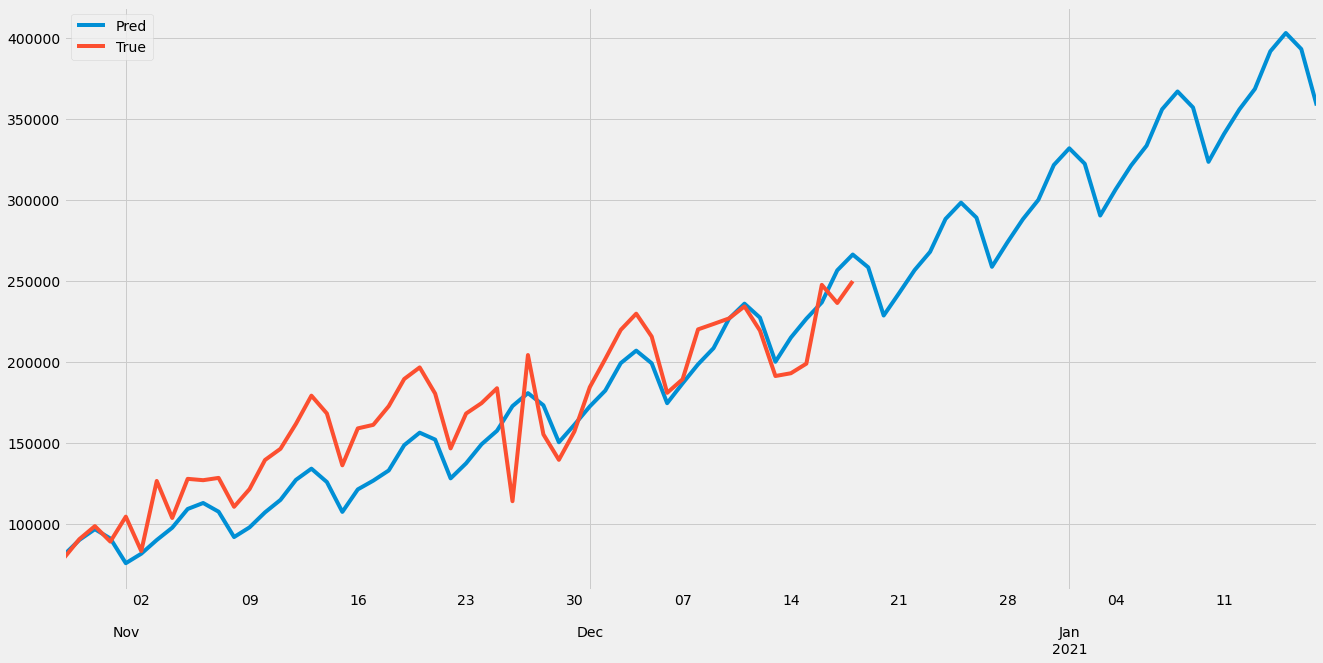

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           NewCases   No. Observations:                  210
Model:             SARIMAX(1, 1, 4)x(4, 0, [], 7)   Log Likelihood                 187.432
Date:                            Thu, 24 Dec 2020   AIC                           -354.865
Time:                                    11:34:56   BIC                           -321.442
Sample:                                04-01-2020   HQIC                          -341.352
                                     - 10-27-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9179      0.100      9.140      0.000       0.721       1.115
ma.L1         -1.3602      0.119    -11.387      0.000      -1.594      -1.126
ma.L2          0.3561      0.124      2.872      0.004       0.113       0.599
ma.L3          0.0370      0.126      0.294      0.769      -0.210       0.284
ma.L4          0.0436      0.082      0.533      0.594      -0.117       0.204
ar.S.L7        0.1847      0.075      2.473      0.013       0.038       0.331
ar.S.L14       0.1952      0.064      3.038      0.002       0.069       0.321
ar.S.L21       0.2037      0.065      3.148      0.002       0.077       0.331
ar.S.L28       0.2579      0.066      3.918      0.000       0.129       0.387
sigma2         0.0093      0.001     11.389      0.000       0.008       0.011
===================================================================================
Ljung-Box (Q):                       41.22   Jarque-Bera (JB):                 8.78
Prob(Q):                              0.42   Prob(JB):                         0.01
Heteroskedasticity (H):               1.82   Skew:                            -0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [399]:
model2 = SARIMAX(train, order =(1,1,4), seasonal_order = (4,0,0,7),
                                       freq = 'D')
fit_model2 = model2.fit(maxiter = 200, disp = False)
yhat = fit_model2.forecast(len(test)+30)
# RMSE = eval_model(fit_model2,test,yhat)
print(f'RMSE = {RMSE}')

test_pred = pd.DataFrame()
test_pred['Pred'] = np.exp(yhat)
test_pred['True'] = np.exp(test)

# test_pred['Error'] = (np.exp(yhat)-np.exp(test))
test_pred.plot(figsize = (20,10))
plt.show()
# sns.kdeplot(test_pred['Error'])
plt.show()
fit_model2.summary()

# pickle.dump(fit_model2, open('SARIMAX_fit_model1.pickle', 'wb'))

The large error on Nov. 26th was because of Thanksgiving.  Fewer people were testing on Thanksgiving, or fewer people were working in the labs.  The increased errors between Nov. 9th and November 26th may be because of increased testing as people prepared to travel for the holiday.  Errors decrease again after this period.

In [327]:
from pmdarima import auto_arima

auto_arima(y=train, start_p=0, start_d=1, start_q=0, 
           max_p=6, max_d=2, max_q=4, 
           seasonal=True, trace=True, D=None, n_jobs=-1, 
           with_intercept=False,suppress_warnings=True, error_action='ignore',
           out_of_sample_size = 0, 
          start_P=0, start_D=0, start_Q=0,
           max_P=7, max_D=2, max_Q=7,
          m=7)

C:\Users\caell\new_Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:74: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-238.930, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7]             : AIC=-300.494, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7]             : AIC=-271.781, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=-236.942, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[7]             : AIC=-325.800, Time=0.15 sec
 ARIMA(1,1,0)(3,0,0)[7]             : AIC=-338.446, Time=0.26 sec
 ARIMA(1,1,0)(4,0,0)[7]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(3,0,1)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(1,1,0)(2,0,1)[7]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(4,0,1)[7]             : AIC=-355.065, Time=1.44 sec
 ARIMA(1,1,0)(5,0,1)[7]             : AIC=-351.120, Time=2.79 sec
 ARIMA(1,1,0)(4,0,2)[7]             : AIC=inf, Time=1.80 sec
 ARIMA(1,1,0)(3,0,2)[7]             : AIC=inf, Time=1.16 sec
 ARIMA(1,1,0)(5,0,0)[7]             : AIC=inf, Time=1.85 sec
 ARIMA(1,1,0)(5,0,2)[7]             : AIC=-356.847, Time=4.13 s

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(5, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

In [315]:
model2 = SARIMAX(train, order =(1,1,4), seasonal_order = (4,0,0,7),
                                       freq = 'D')

TypeError: __new__() got an unexpected keyword argument 'seasonal_order'

C:\Users\caell\new_Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE = 263662.92369540187


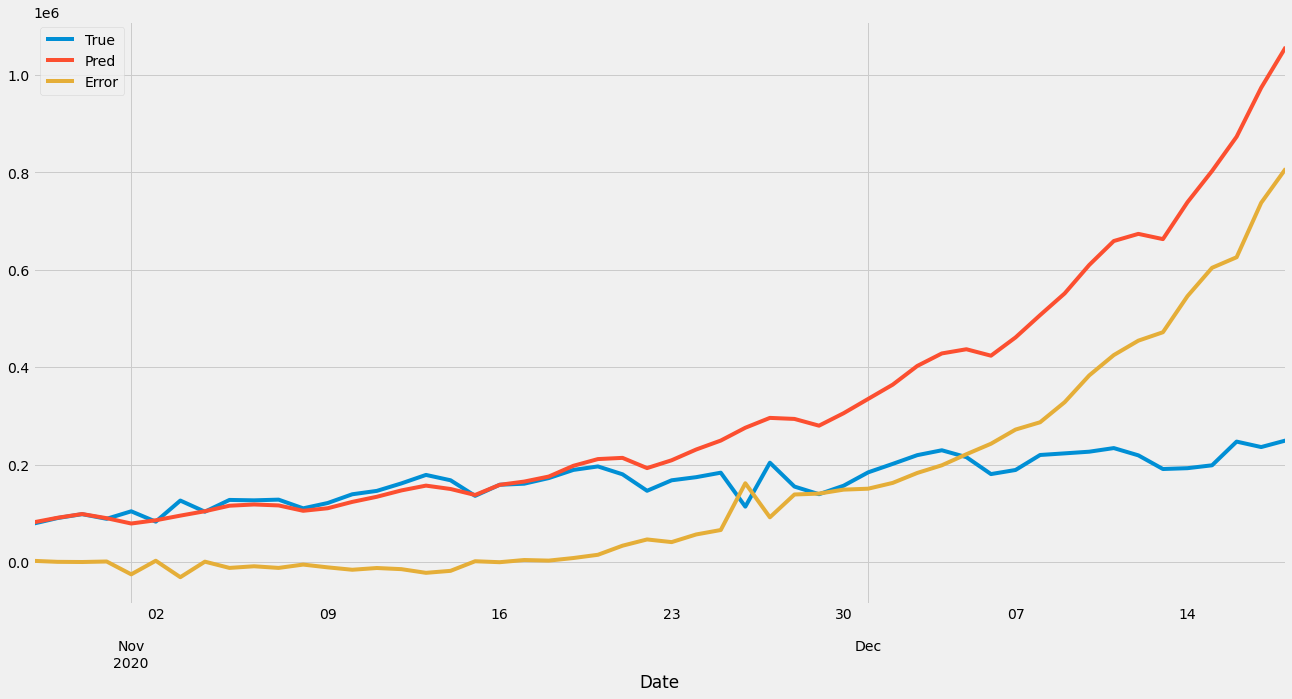

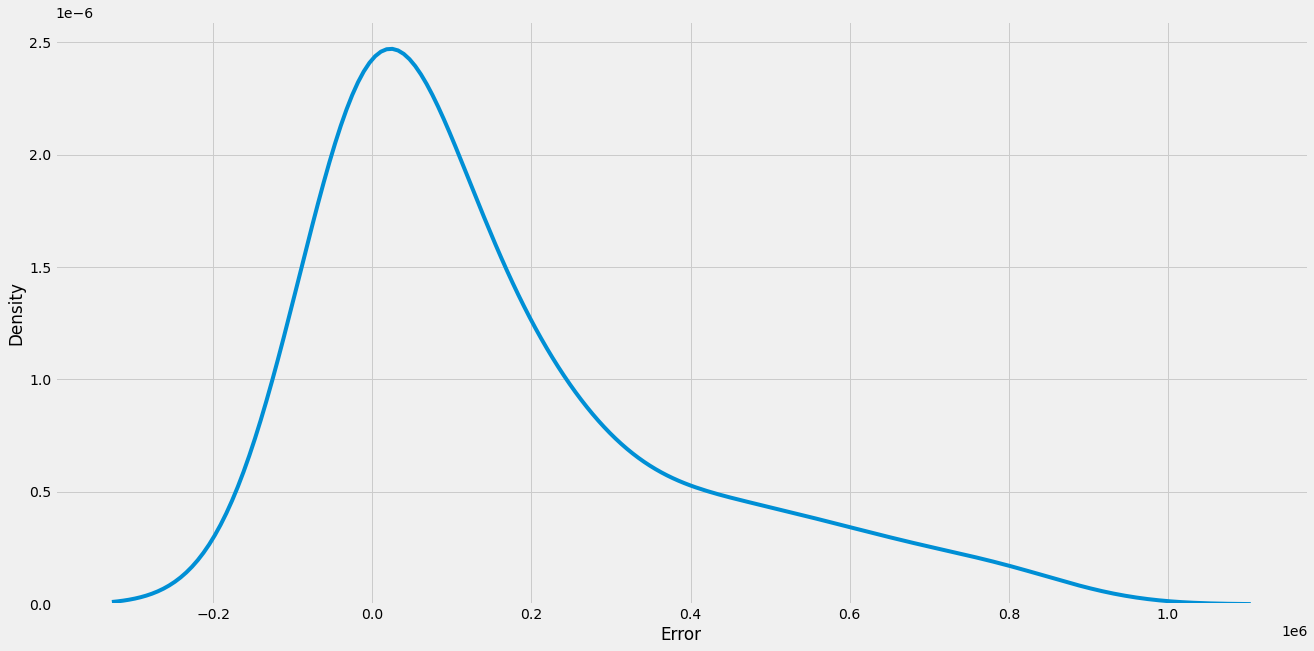

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           NewCases   No. Observations:                  210
Model:             SARIMAX(5, 2, 3)x(4, 0, [], 7)   Log Likelihood                 167.736
Date:                            Wed, 23 Dec 2020   AIC                           -305.471
Time:                                    10:56:25   BIC                           -255.408
Sample:                                04-01-2020   HQIC                          -285.228
                                     - 10-27-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0012      0.008     -0.148      0.883      -0.017       0.015
drift       1.107e-05   6.97e-05      0.159      0.874      -0.000       0.000
ar.L1         -0.7597      0.539     -1.410      0.159      -1.816       0.297
ar.L2         -0.6795      0.415     -1.636      0.102      -1.493       0.134
ar.L3         -0.6268      0.275     -2.276      0.023      -1.167      -0.087
ar.L4         -0.5414      0.214     -2.525      0.012      -0.962      -0.121
ar.L5         -0.3427      0.140     -2.442      0.015      -0.618      -0.068
ma.L1         -0.3973      0.537     -0.740      0.459      -1.450       0.655
ma.L2          0.0068      0.424      0.016      0.987      -0.824       0.837
ma.L3          0.0531      0.245      0.217      0.828      -0.427       0.533
ar.S.L7        0.1136      0.154      0.737      0.461      -0.188       0.416
ar.S.L14       0.1415      0.087      1.636      0.102      -0.028       0.311
ar.S.L21       0.1296      0.083      1.561      0.118      -0.033       0.292
ar.S.L28       0.3000      0.079      3.787      0.000       0.145       0.455
sigma2         0.0113      0.001      8.389      0.000       0.009       0.014
===================================================================================
Ljung-Box (Q):                       72.20   Jarque-Bera (JB):                 2.35
Prob(Q):                              0.00   Prob(JB):                         0.31
Heteroskedasticity (H):               1.76   Skew:                            -0.16
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [391]:
model3 = SARIMAX(train,order=(5, 2, 3), seasonal_order=(4, 0, 0, 7),
      suppress_warnings=True, trend='ct')
fit_model3 = model3.fit()
yhat = fit_model3.forecast(len(test))
RMSE = eval_model(fit_model3,test,yhat)
print(f'RMSE = {RMSE}')

test_pred = pd.DataFrame()
test_pred['True'] = np.exp(test)
test_pred['Pred'] = np.exp(yhat)
test_pred['Error'] = (np.exp(yhat)-np.exp(test))
test_pred.plot(figsize = (20,10))
plt.show()
sns.kdeplot(test_pred['Error'])
plt.show()
fit_model3.summary()

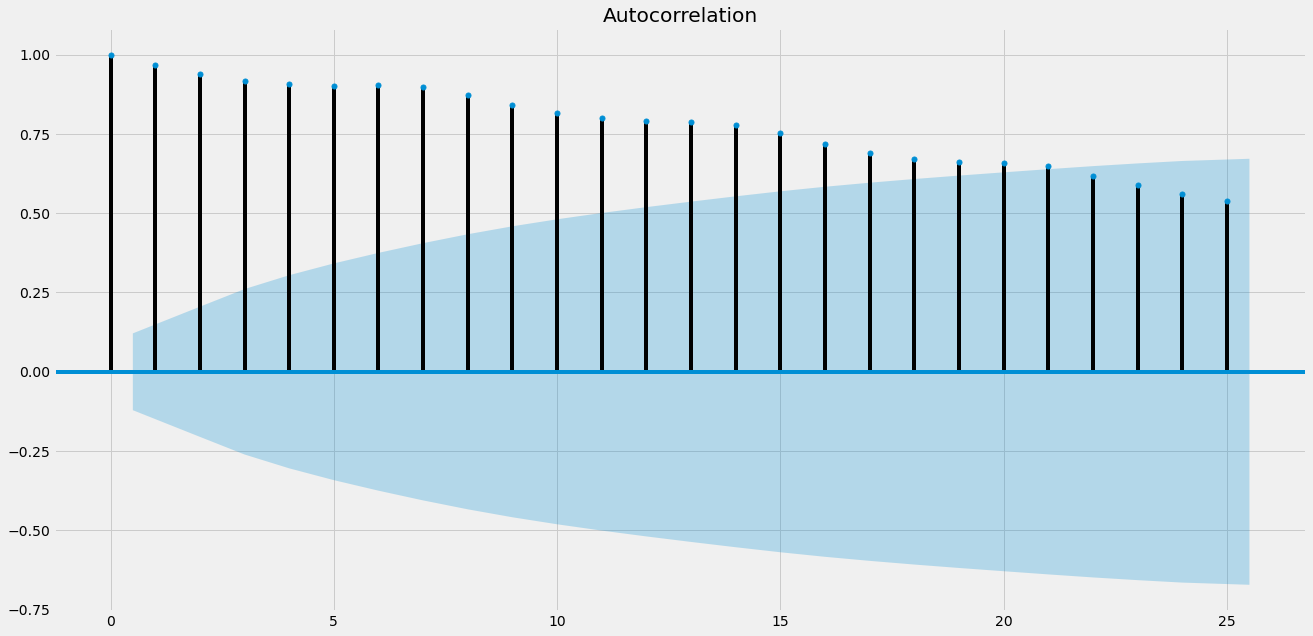

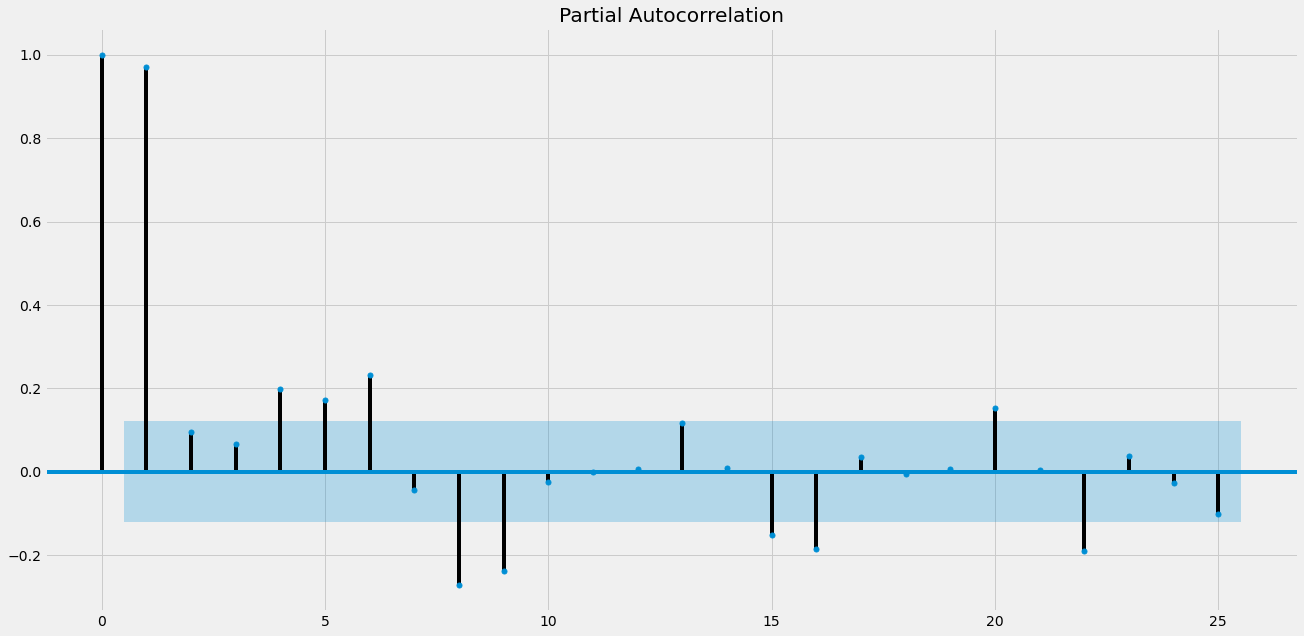

In [378]:
plot_acf(true.dropna())
plt.show()
plot_pacf(true.dropna())
plt.show()